In [13]:
!pip install xgboost matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
power_data = pd.read_csv('artifacts/power_cleaned_data.csv')
power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,886.17
1,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,1071.01
2,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,1143.00
3,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,931.46
4,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,441.20


In [3]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data['Patv'] < 0,
            (self.data['Wspd'] < 1) & (self.data['Patv'] > 10),
            (self.data['Wspd'] < 2) & (self.data['Patv'] > 100),
            (self.data['Wspd'] < 3) & (self.data['Patv'] > 200),
            (self.data['Wspd'] > 2.5) & (self.data['Patv'] == 0),
            (self.data['Wspd'] == 0) & (self.data['Wdir'] == 0) & (self.data['Etmp'] == 0),
            self.data['Etmp'] < -21,
            self.data['Itmp'] < -21,
            self.data['Etmp'] > 60,
            self.data['Itmp'] > 70,
            (self.data['Wdir'] > 180) | (self.data['Wdir'] < -180),
            (self.data['Ndir'] > 720) | (self.data['Ndir'] < -720),
            (self.data['Pab1'] > 89) | (self.data['Pab2'] > 89) | (self.data['Pab3'] > 89)
        ]
        
        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition
        
        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data

# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
2588,1,78,01:30,3.19,1.74,31.47,40.79,-29.63,0.99,0.99,0.99,-0.25,129.64
269,1,56,04:10,9.58,-4.62,30.39,43.09,8.20,1.00,1.00,1.00,-0.24,1237.39
629,1,58,18:30,7.12,0.09,28.94,39.14,244.08,1.00,1.00,1.00,-0.24,762.42
1730,1,70,22:20,5.99,2.29,35.31,43.90,303.76,1.00,1.00,1.00,-0.24,439.01
1033,1,63,10:50,5.75,0.67,33.88,43.66,75.57,0.99,0.99,0.99,-0.26,437.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1,64,07:30,7.42,2.84,31.09,38.78,39.67,1.00,1.00,1.00,-0.27,668.30
1294,1,65,14:50,5.66,3.42,39.05,48.34,19.73,1.09,1.09,1.08,-0.02,314.80
860,1,60,15:30,8.62,3.29,38.04,49.27,416.92,1.00,1.00,1.00,-0.31,1061.76
3507,1,86,14:40,6.71,1.91,34.70,44.53,223.51,1.00,1.00,1.00,-0.21,688.53


In [4]:
# encode Tmstamp column to numeric values
train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_52421/3317315984.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_52421/3317315984.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9


<Axes: >

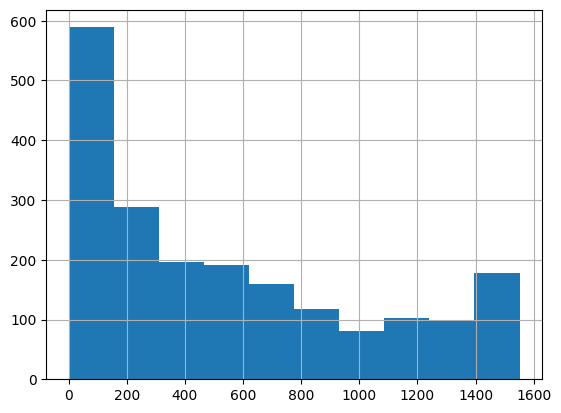

In [5]:
train["Patv"].hist()

<Axes: >

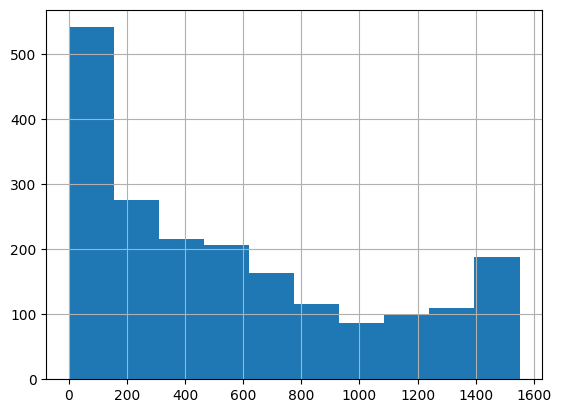

In [6]:
test["Patv"].hist()

In [7]:
# Split the data into training and testing sets
X = train.drop(columns=['Patv'])
y = train['Patv']

X_test = test.drop(columns=['Patv'])
y_test = test['Patv']

# Train an XGBoost model 
model = XGBRegressor()
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1251.4529064359335
Mean Absolute Error: 20.408584720100553


### GAN synthesized data

In [ ]:
from synthetic_energy.time_series import DGAN, DGANConfig


features = train.to_numpy()
n_time_points = 2
n = features.shape[0] // n_time_points
features = features[: n * n_time_points, :].reshape(
    -1, n_time_points, features.shape[1]
)

config = DGANConfig(max_sequence_len=20, sample_len=5, batch_size=10, epochs=10, cuda=False)
dg = DGAN(config=config)

dg.train_numpy(
    features=features,
)

attributes, features = dg.generate_numpy(n=100)

print(features[0])

2024-12-04 00:05:16 [info     ] Training DGAN model            dtype=dtype('float64') features_length=1000 first_sequence_shape=(2, 13)
2024-12-04 00:05:16 [info     ] Determining outputs metadata from input data
2024-12-04 00:05:16 [info     ] Building DGAN networks        
2024-12-04 00:05:16 [info     ] Checking for nans in the numeric columns number_of_columns=13
2024-12-04 00:05:16 [info     ] Applying linear interpolations for nans (does not mean nans are present)
2024-12-04 00:05:16 [info     ] Creating encoded array of features
2024-12-04 00:05:16 [info     ] Creating encoded array of attributes
2024-12-04 00:05:16 [info     ] Training...                    dtype=dtype('float32') internal_additional_attributes_shape=(1000, 26) internal_attributes_shape=(1000, 1) internal_features_shape=(1000, 20, 13)
2024-12-04 00:05:16 [info     ] Creating TensorDataset        
2024-12-04 00:05:16 [info     ] Calling _train()              
2024-12-04 00:05:16 [info     ] Training              

In [ ]:
import numpy as np
import pandas as pd

# Define the column names
columns = ["TurbID", "Day", "Tmstamp", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]

# Convert the generated list to a NumPy array
features_array = np.array(features)

# Reshape the array and convert it to a DataFrame
synthetic_df = pd.DataFrame(features_array.reshape(-1, features_array.shape[-1]), columns=columns)

synthetic_df

In [ ]:
synthetic_df["Patv"].hist()

In [ ]:
cleaned_data["Patv"].hist()

In [ ]:
# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(synthetic_df)
synthesized_cleaned_data = cleaner.clean_data()

# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
synthesized_cleaned_data.head()

In [ ]:
# Assuming synthesized_cleaned_data is your DataFrame
synthesized_cleaned_data = synthesized_cleaned_data.astype(float)

In [ ]:
synthesized_cleaned_data['Tmstamp'] = pd.to_datetime(synthesized_cleaned_data['Tmstamp']).astype(int) // 10**9

In [ ]:
synthesized_cleaned_data.dtypes

In [ ]:
# Split the data into training and testing sets
X = synthesized_cleaned_data.drop(columns=['Patv'])
y = synthesized_cleaned_data['Patv']


# Train an XGBoost model 
model = XGBRegressor()
model.fit(X, y)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

In [ ]:
synthetic_df

In [ ]:
from synthetic_energy.quality_metrics import (
    WassersteinDistance,
    KLDivergence,
    PopulationStabilityIndex
)
from sklearn.preprocessing import MinMaxScaler

# Defines a small constant to avoid zero probabilities
epsilon = 1e-10
original_data = subset_power_data.values + epsilon
synthetic_data = synthetic_df.values + epsilon

# Normalize the data
scaler = MinMaxScaler()
original_data_normalized = scaler.fit_transform(original_data)
synthetic_data_normalized = scaler.transform(synthetic_data)

# Calculate the Wasserstein distance between the original and synthetic data
wd = WassersteinDistance()
wd_value = wd._distance(original_data_normalized, synthetic_data_normalized)
print(f'Wasserstein Distance: {wd_value}')

# Calculate the Kullback-Leibler divergence between the original and synthetic data
kl = KLDivergence()
kl_value = kl._distance(original_data_normalized, synthetic_data_normalized)
print(f'KL Divergence: {kl_value}')

# Calculate the Population Stability Index between the original and synthetic data
psi = PopulationStabilityIndex()
psi_value = psi._distance(original_data_normalized, synthetic_data_normalized)
print(f'Population Stability Index: {psi_value}')


In [ ]:
synthetic_df.shape

In [ ]:
subset_power_data.shape

In [ ]:
from sklearn.manifold import TSNE

# Combine the original and synthetic data for t-SNE visualization
combined_data = np.vstack((subset_power_data.values, synthetic_df.values))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = ['Original'] * len(subset_power_data) + ['Synthetic'] * len(synthetic_df)

# Plot the results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [ ]:
subset_power_data